In this study, we look at how the difference between st22 and the trolley behave. In this data set, the trolley is directly underneath station 22.
The difference has been made positive (absolute value of the difference)

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

#import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools

In [3]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':10, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in y:
        Sum += i
        if (np.where(y == i)[0][0]% avgt == 0) and (np.where(y == i)[0][0] > 0):
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def MovingAvg(x, bin_size):
    i = 0
    avg = np.array([])
    while (i <= len(x) - bin_size):
        Sum = 0
        j = 0
        while (j < bin_size):
            Sum += x[i + j]
            j += 1
        avg = np.append(avg, Sum/bin_size)
        if(i % 86400 == 0):
            print(str(i) + "iterations done")
        i +=1
    return avg
        
def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)

def ArrayRound(array, value):
    #For a 1-D array of values that are non-decreasing everywhere. Returns the element of the array closest to the value given
    inf = -1
    sup = -1
    if array[0] >= value:
        return array[0]
    else:
        for number in array:
            if number <= value:
                inf = number
        if inf == value:
            return value
        else:
            sup = array[np.where(array == inf)[0] +1]
            if abs(inf - value) < abs(sup - value):
                return inf
            elif abs(inf-value) > abs(sup - value):
                return sup
            else:
                print("The closest the value provided is exactly in between two elements of the array, the lower element has been returned.")
                return inf
        
    
def DayLineFit(time_data, y_data, start):
    #Fits lines on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    slopes = np.array([])
    intercepts = np.array([])
    test = np.array([step, step + (day*difference)])
    while step + 86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference)])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]]])
        z = np.polyfit(x,y,1)
        slopes = np.append(slopes, z[0])
        intercepts = np.append(intercepts, z[1])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return slopes, intercepts

def DayParFit(time_data, y_data, start):
    #Fits parabola on points 24 hours apart. Assuming the time data is in seconds, takes into account any binning done
    #Assumes time_data points are equally spaced; hence the the difference variable
    step = ArrayRound(time_data, start)
    difference = time_data[1] - time_data[0]
    day = int(round(86400/difference,0))
    a = np.array([])
    b = np.array([])
    c = np.array([])
    while step + 2*86400 <= time_data[-1]:
        x = np.array([step, step + (day*difference), step + (2*(day*difference))])
        y = np.array([y_data[np.where(time_data == step)[0]], y_data[np.where(time_data == step + (day*difference))[0]], y_data[np.where(time_data == step + (2*(day*difference)))[0]]])
        z = np.polyfit(x,y,2)
        a = np.append(a, z[0])
        b = np.append(b, z[1])
        c = np.append(c, z[2])
        step = time_data[np.where(time_data == step)[0][0] +1]
    return a, b, c

def LogSlope(x,y,a): #Returns the slope of a graph at x = a, a is the actual number, not log of the point of interest.
    figwidth = 13
    figheight = 5
    a = ArrayRound(x,a)
    t = np.where(x == a)[0][0]
    diff_y32 = np.log10(y[t + 1]) - np.log10(y[t])
    diff_x32 = np.log10(x[t + 1]) - np.log10(x[t])
    diff_y21 = np.log10(y[t]) - np.log10(y[t-1])
    diff_x21 = np.log10(x[t]) - np.log10(x[t-1])
    m = (.5*(diff_y32/diff_x32)) + (.5*(diff_y21/diff_x21))
    b = np.log10(y[t]) - m * np.log10(x[t])
    line = (10** b) * (x ** m)
    
    fig, axs = plt.subplots(1, 1, constrained_layout=True)
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    axs.plot(x,y)
    axs.plot(x, line, 'c', label = "y = " + str(np.round(m,2)) + "x + " + str(np.round(b, 2)))
    axs.plot([x[t]], [y[t]],'o', 'k')
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.legend()
    axs.set_ylim(min(y), max(y))
    axs.set_aspect('equal')
    plt.show()
    
def cos(x, A, phi):
    period = 86400
    return A * np.cos(2 * np.pi * x / period  + phi)

def ResSquare(obs, exp):
    s = 0
    if(len(obs)!= len(exp)):
        print("The length of the arrays in the ResSquare function are not equal")
    for i in range(len(obs)):
        s += (obs[i] - exp[i])**2
    return s

def Variance(obs, exp, dof):
    return ResSquare(obs, exp)/dof

def Chi2(obs, exp, variance):
    return ResSquare(obs, exp)/variance

def Ftest(chi21, chi22, nu2):
    return nu2 * (chi21 - chi22) / chi22


def Harmonics(x, y, variance, GuessForAAndPhi = None): #Fitting function with F test included, this is only for Cosine  as of now.
    vars1, cov1 = curve_fit(cos, x, y, GuessForAAndPhi)
    period = 86400
    A = vars1[0]
    phi = vars1[1]
    w = 2 * np.pi /period
    def harm2(x, B):
        return(cos(x, A, phi) + B * np.cos(2*w*x + phi))
    vars2, cov2 = curve_fit(harm2, x, y)
    B = vars2[0]
    chi21 = Chi2(y, cos(x, A, phi), variance)
    chi22 = Chi2(y, harm2(x,B), variance)
    terms = 1
    nu2 = len(x) - terms - 1
    F = Ftest(chi21, chi22, nu2)
    print("F_1,2 = " + str(F) + "would you like to add another term? yes[y], no[n]")
    addTerm = raw_input()
    Y = y - harm2(x,B)
    Amplitudes = np.array([phi,A])
    zeros = np.zeros(len(Y))
    if(addTerm == 'y'):
        Amplitudes = np.append(Amplitudes, B)
        
    while addTerm == 'y':
        terms += 1
        def NewTerm(t, C):
            return C * np.cos((terms + 1) * w * t + phi)
        vars3, cov3 = curve_fit(NewTerm, x, Y)
        C = vars3[0]
        chi21 = Chi2(Y,zeros, variance)
        chi22 = Chi2(Y, NewTerm(x,C), variance)
        nu2 = len(x) - terms - 1
        F = Ftest(chi21, chi22, nu2)
        print("F_" + str(terms) + "," + str(terms + 1) + " = " + str(F) + "would you like to add another term? yes[y], no[n]")
        addTerm = raw_input()
        if (addTerm == 'y'):
            Amplitudes = np.append(Amplitudes, C)
        Y = Y - NewTerm(x, C)
    print("You entered something other than y, no more harmonics added. Last harmonic was number " + str(terms))
    print("All you need is to use the fuction BestFit and enter the coefficient array output by this function. The first coefficient is phi")
    return Amplitudes

def BestFit(x, Amplitudes): #Only use arrays output by the Harmonics function if you are unsure of how this function works. First element is phi, rest are amplitude coeff.
    Coeff = Amplitudes
    period = 86400
    w = 2 * np.pi / period
    phi = Amplitudes[0]
    Sum = Coeff[1] * np.cos(w * x + phi) 
    for i in range(len(Amplitudes) - 2):
        Sum += Coeff[i + 2] * np.cos((i + 2)*w*x + phi)
    return Sum

In [4]:
filename = 'hdf5/superlong_1.h5'
sl_interp_df = pd.read_hdf(filename)
#sl_interp_df.head()

In [5]:
sl_moment_df = helper.calc_moment_df(sl_interp_df)

Finished calculating all moments for 252363 events.       


In [6]:
#Running before remmoval of data points to show the difference in the allan deviations.
T = sl_moment_df.index.to_numpy()
st22m1_list = sl_moment_df["st22,m1"].to_numpy()
trm1_list   = sl_moment_df["tr,m1"].to_numpy()

st22m2_list = sl_moment_df["st22,m2"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()

st22m3_list = sl_moment_df["st22,m3"].to_numpy()
trm3_list   = sl_moment_df["tr,m3"].to_numpy()

st22m4_list = sl_moment_df["st22,m4"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()

st22m5_list = sl_moment_df["st22,m5"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()

st22m6_list = sl_moment_df["st22,m6"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()

y1 = abs(trm1_list - st22m1_list) #The m1 measured by the station is higher always
y2 = abs(trm2_list - st22m2_list) #The m2 measured by the trolley is higher always
y3 = abs(trm3_list - st22m3_list) #The m3 measured by the trolley is higher always
y4 = abs(trm4_list - st22m4_list) #The m4 measured by the trolley is higher always
y5 = abs(trm5_list - st22m5_list) #The m5 measured by the trolley is higher always
y6 = abs(trm6_list - st22m6_list) #The m6 measured by the trolley is higher always

t = np.logspace(0, math.log(len(st22m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(tb1, adb1, ade, adn) = allantools.oadev(y1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tb2, adb2, ade, adn) = allantools.oadev(y2, rate=r, data_type="freq", taus = t)
(tb3, adb3, ade, adn) = allantools.oadev(y3, rate=r, data_type="freq", taus = t)  
(tb4, adb4, ade, adn) = allantools.oadev(y4, rate=r, data_type="freq", taus = t)
(tb5, adb5, ade, adn) = allantools.oadev(y5, rate=r, data_type="freq", taus = t) 
(tb6, adb6, ade, adn) = allantools.oadev(y6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtb1 = tb1[np.where(adb1==adb1.min())][0]
avgtb2 = tb2[np.where(adb2==adb2.min())][0]
avgtb3 = tb3[np.where(adb3==adb3.min())][0]
avgtb4 = tb4[np.where(adb4==adb4.min())][0]
avgtb5 = tb5[np.where(adb5==adb5.min())][0]
avgtb6 = tb6[np.where(adb6==adb6.min())][0]

In [7]:
run_start = sl_moment_df.index.values[0] #I forgot to keep the times on arrays, was still getting used to CST time
time_deleted = 61200
sl_moment_df = sl_moment_df.drop(np.arange(run_start, run_start + time_deleted)) #deleting the drift part

In [8]:
T = sl_moment_df.index.to_numpy()
st22m1_list = sl_moment_df["st22,m1"].to_numpy()
trm1_list   = sl_moment_df["tr,m1"].to_numpy()

st22m2_list = sl_moment_df["st22,m2"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()

st22m3_list = sl_moment_df["st22,m3"].to_numpy()
trm3_list   = sl_moment_df["tr,m3"].to_numpy()

st22m4_list = sl_moment_df["st22,m4"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()

st22m5_list = sl_moment_df["st22,m5"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()

st22m6_list = sl_moment_df["st22,m6"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()

In [9]:
#difference between trolley and station 22
y1 = trm1_list - st22m1_list #The m1 measured by the station is higher always
y2 = trm2_list - st22m2_list #The m2 measured by the trolley is higher always
y3 = trm3_list - st22m3_list #The m3 measured by the trolley is higher always
y4 = trm4_list - st22m4_list #The m4 measured by the trolley is higher always
y5 = trm5_list - st22m5_list #The m5 measured by the trolley is higher always
y6 = trm6_list - st22m6_list #The m6 measured by the trolley is higher always

In [10]:
t = np.logspace(0, math.log(len(st22m1_list),10), num = 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(t1, ad1, ade, adn) = allantools.oadev(y1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(t2, ad2, ade, adn) = allantools.oadev(y2, rate=r, data_type="freq", taus = t)
(t3, ad3, ade, adn) = allantools.oadev(y3, rate=r, data_type="freq", taus = t)  
(t4, ad4, ade, adn) = allantools.oadev(y4, rate=r, data_type="freq", taus = t)
(t5, ad5, ade, adn) = allantools.oadev(y5, rate=r, data_type="freq", taus = t) 
(t6, ad6, ade, adn) = allantools.oadev(y6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgt1 = t1[np.where(ad1==ad1.min())][0]
avgt2 = avgt1#t2[np.where(ad2==ad2.min())][0]
avgt3 = avgt1#t3[np.where(ad3==ad3.min())][0]
avgt4 = avgt1#t4[np.where(ad4==ad4.min())][0]
avgt5 = avgt1#t5[np.where(ad5==ad5.min())][0]
avgt6 = avgt1#t6[np.where(ad6==ad6.min())][0]
#avgt2 = avgtb2

In [11]:
#y_axis_labels = np.array(["Allan Deviation in Hz"])
#x_axis_labels = np.array(["Averaging time"])
#sublabels = np.array(["m1", "m2", "m3", "m4", "m5", "m6"])
#x_data = np.array([t1, t2, t3, t4, t5, t6])
#y_data = np.array([ad1, ad2, ad3, ad4, ad5, ad6])
#Multiplot(x_data, y_data, 5, 13, [2,3], sublabels, x_axis_labels, y_axis_labels, figname = "Creative title", logscale = True, daylines = True)

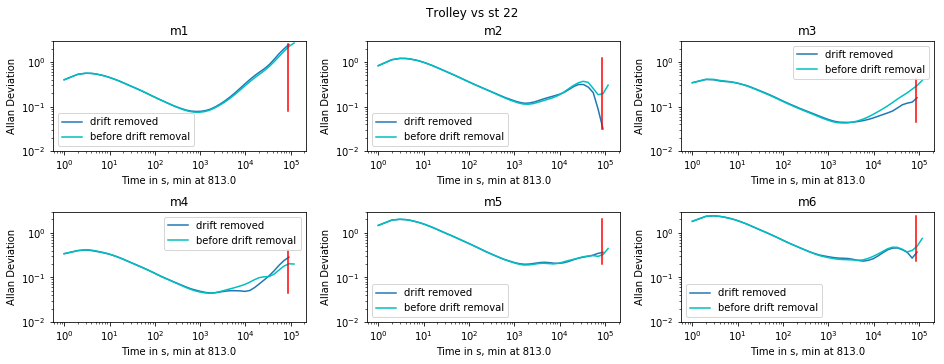

In [12]:
#Plots Allan Deviation
day  = np.array([86400, 86400])
ad1m = np.array([min(ad1), max(ad1)])
ad2m = np.array([min(ad2), max(ad2)])
ad3m = np.array([min(ad3), max(ad3)])
ad4m = np.array([min(ad4), max(ad4)])
ad5m = np.array([min(ad5), max(ad5)])
ad6m = np.array([min(ad6), max(ad6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True) #This is St22 vs Trolley
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(t1, ad1, label = "drift removed")
axs[0,0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0,0].plot([86400,86400],[ad1.min(), ad1.max()], 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_ylim(.01,3)                                                                          
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s, min at " + str(avgt1))
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(t2,ad2, label = "drift removed")
axs[0,1].plot(tb2,adb2, 'c', label = "before drift removal")
axs[0,1].plot([86400,86400],[ad2.min(), ad2.max()], 'r')
axs[0,1].set_ylim(.01,3)                                                                          
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s, min at " + str(avgt2))
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(t3,ad3, label = "drift removed")
axs[0,2].plot(tb3,adb3, 'c', label = "before drift removal")
axs[0,2].plot([86400,86400],[ad3.min(), ad3.max()], 'r')
axs[0,2].set_ylim(.01,3)                                                                          
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s, min at " + str(avgt3))
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(t4,ad4, label = "drift removed")
axs[1,0].plot(tb4,adb4, 'c', label = "before drift removal")
axs[1,0].plot([86400,86400],[ad4.min(), ad4.max()], 'r')
axs[1,0].set_ylim(.01,3)                                                                          
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s, min at " + str(avgt4))
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(t5,ad5, label = "drift removed")
axs[1,1].plot(tb5,adb5, 'c', label = "before drift removal")
axs[1,1].plot([86400,86400],[ad5.min(), ad5.max()], 'r')
axs[1,1].set_ylim(.01,3)                                                                          
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s, min at " + str(avgt5))
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(t6,ad6, label = "drift removed")
axs[1,2].plot(tb6,adb6, 'c', label = "before drift removal")
axs[1,2].plot([86400,86400],[ad6.min(), ad6.max()], 'r')
axs[1,2].set_ylim(.01,3)                                                                          
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s, min at " + str(avgt6))
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs st 22")

plt.show()

In [13]:
#Fitting a line through the unbinned data (Correlation)
vars1, cov1 = curve_fit(line,trm1_list, st22m1_list)
print("m = " + str(vars1[0]) + " +- " + str(cov1[0]))
vars2, cov2 = curve_fit(line,trm2_list, st22m2_list)
print("m = " + str(vars2[0]) + " +- " + str(cov2[0]))
vars3, cov3 = curve_fit(line,trm3_list, st22m3_list)
print("m = " + str(vars3[0]) + " +- " + str(cov3[0]))
vars4, cov4 = curve_fit(line,trm4_list, st22m4_list)
print("m = " + str(vars4[0]) + " +- " + str(cov4[0]))
vars5, cov5 = curve_fit(line,trm5_list, st22m5_list)
print("m = " + str(vars5[0]) + " +- " + str(cov5[0]))
vars6, cov6 = curve_fit(line,trm6_list, st22m6_list)
print("m = " + str(vars6[0]) + " +- " + str(cov6[0]))

m = 1.0337021551281127 +- [ 1.0700656e-09 -5.4169329e-05]
m = 0.9531000757165793 +- [2.04674119e-06 5.47779217e-05]
m = 0.6862107177076332 +- [1.70108970e-06 2.43830872e-04]
m = 0.665271879008225 +- [1.76145365e-06 4.17734225e-04]
m = 0.4588095277279505 +- [9.85995016e-05 5.04669887e-03]
m = 0.03783987995644944 +- [ 9.30828881e-05 -1.17264245e-02]


Text(0.5,0.98,'trolley and st22')

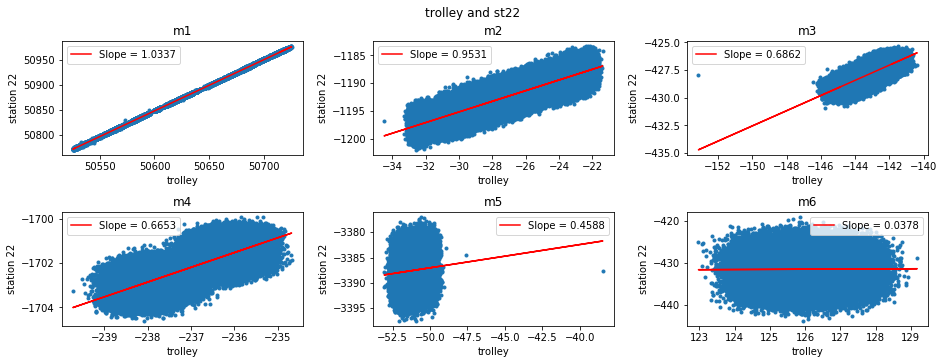

In [14]:
#Plotting the data with the line of best fit
fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(trm1_list, st22m1_list,'.')
axs[0,0].plot(trm1_list, line(trm1_list, *vars1), 'r', label = "Slope = " + str(round(vars1[0], 4)))
axs[0,0].set_xlabel("trolley")
axs[0,0].set_ylabel("station 22")
axs[0,0].set_title("m1")
axs[0,0].legend()

axs[0,1].plot(trm2_list, st22m2_list,'.')
axs[0,1].plot(trm2_list, line(trm2_list, *vars2), 'r', label = "Slope = " + str(round(vars2[0], 4)))
axs[0,1].set_xlabel("trolley")
axs[0,1].set_ylabel("station 22")
axs[0,1].set_title("m2")
axs[0,1].legend()

axs[0,2].plot(trm3_list, st22m3_list,'.')
axs[0,2].plot(trm3_list, line(trm3_list, *vars3), 'r', label = "Slope = " + str(round(vars3[0], 4)))
axs[0,2].set_xlabel("trolley")
axs[0,2].set_ylabel("station 22")
axs[0,2].set_title("m3")
axs[0,2].legend()

axs[1,0].plot(trm4_list, st22m4_list,'.')
axs[1,0].plot(trm4_list, line(trm4_list, *vars4), 'r', label = "Slope = " + str(round(vars4[0], 4)))
axs[1,0].set_xlabel("trolley")
axs[1,0].set_ylabel("station 22")
axs[1,0].set_title("m4")
axs[1,0].legend()

axs[1,1].plot(trm5_list, st22m5_list,'.')
axs[1,1].plot(trm5_list, line(trm5_list, *vars5), 'r', label = "Slope = " + str(round(vars5[0], 4)))
axs[1,1].set_xlabel("trolley")
axs[1,1].set_ylabel("station 22")
axs[1,1].set_title("m5")
axs[1,1].legend()

axs[1,2].plot(trm6_list, st22m6_list,'.')
axs[1,2].plot(trm6_list, line(trm6_list, *vars6), 'r', label = "Slope = " + str(round(vars6[0], 4)))
axs[1,2].set_xlabel("trolley")
axs[1,2].set_ylabel("station 22")
axs[1,2].set_title("m6")
axs[1,2].legend()

fig.suptitle("trolley and st22")

In [17]:
#Binning data
#(T1_safe, D1) =  difference(y1,avgt1)
#print("1 runs done")
#(T2_safe, D2) =  difference(y2,avgt2)
#print("2 runs done")
#(T3_safe, D3) =  difference(y3,avgt3)
#print("3 runs done")
#(T4_safe, D4) =  difference(y4,avgt4)
#print("4 runs done")
#(T5_safe, D5) =  difference(y5,avgt5)
#rint("5 runs done")
#(T6_safe, D6) =  difference(y6,avgt6)
#print("6 runs done")

deletes = np.linspace(0, 7198, 7199)
deletes = deletes.astype(int)
T1_safe = np.delete(T, deletes)
T1_safe = T1_safe - 7200 + (7200-1) * .5
T2_safe = T1_safe 
T3_safe = T1_safe 
T4_safe = T1_safe 
T5_safe = T1_safe 
T6_safe = T1_safe 

D1 = MovingAvg(y1, 7200)
print("m1 done")
D2 = MovingAvg(y2, 7200)
print("m2 done")
D3 = MovingAvg(y3, 7200)
print("m3 done")
D4 = MovingAvg(y4, 7200)
print("m4 done")
D5 = MovingAvg(y5, 7200)
print("m5 done")
D6 = MovingAvg(y6, 7200)
print("m6 done")

0iterations done
86400iterations done
172800iterations done
m1 done
0iterations done
86400iterations done
172800iterations done
m2 done
0iterations done
86400iterations done
172800iterations done
m3 done
0iterations done
86400iterations done
172800iterations done
m4 done
0iterations done
86400iterations done
172800iterations done
m5 done
0iterations done
86400iterations done
172800iterations done
m6 done


In [19]:
T1_safe = np.delete(T, deletes)
T1_safe = T1_safe - 7200 + (7200-1) * .5
T2_safe = T1_safe 
T3_safe = T1_safe 
T4_safe = T1_safe 
T5_safe = T1_safe 
T6_safe = T1_safe 

In [20]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
T1   = T1_safe   #+ run_start + time_deleted
T2   = T2_safe   #+ run_start + time_deleted
T3   = T3_safe   #+ run_start + time_deleted
T4   = T4_safe   #+ run_start + time_deleted
T5   = T5_safe   #+ run_start + time_deleted
T6   = T6_safe   #+ run_start + time_deleted

In [21]:
#T = np.array([T1,T2,T3,T4,T5,T6])
#Y = np.array([D1,D2,D3,D4,D5,D6])
#x_axis_labels = np.array(["Time"])
#y_axis_labels = np.array(["Difference"])
#day_offset = -time_deleted
#Multiplot(T, Y, 5, 13, [2,3], sublabels,x_axis_labels, y_axis_labels, "creative name", CST = True, daylines = True)

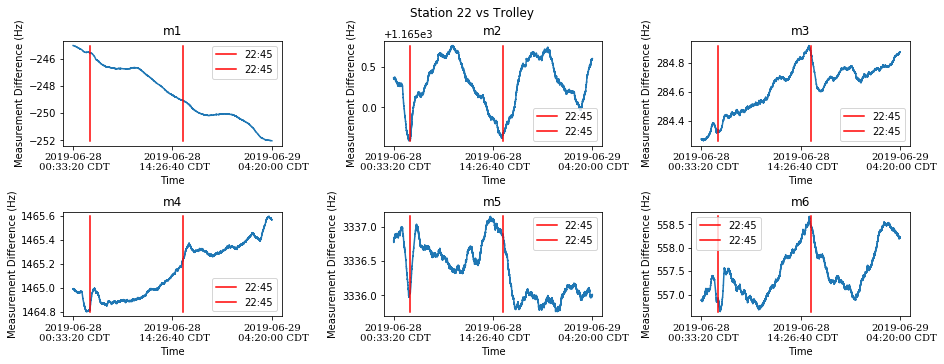

In [22]:
#Plotting Binned data:
T1 = np.delete(T1, 0)    #Trolley vs st 22
D1 = np.delete(D1, 0)
T2 = np.delete(T2, 0)
D2 = np.delete(D2, 0)
T3 = np.delete(T3, 0)
D3 = np.delete(D3, 0)
T4 = np.delete(T4, 0)
D4 = np.delete(D4, 0)
T5 = np.delete(T5, 0)
D5 = np.delete(D5, 0)
T6 = np.delete(T6, 0)
D6 = np.delete(D6, 0)

l1 = D1.min()            
h1 = D1.max()
l2 = D2.min()
h2 = D2.max()
l3 = D3.min()
h3 = D3.max()
l4 = D4.min()
h4 = D4.max()
l5 = D5.min()
h5 = D5.max()
l6 = D6.min()
h6 = D6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(T1 , D1)
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
#axs[0,0].plot([T1[0] + 61200, T1[0] + 61200], [l1,h1], 'k', label = "cutoff")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(T2 , D2)
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
#axs[0,1].plot([T2[0] + 61200, T2[0] + 61200], [l2,h2], 'k', label = "cutoff")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(T3 , D3)
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
#axs[0,2].plot([T3[0] + 61200, T3[0] + 61200], [l3,h3], 'k', label = "cutoff")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(T4 , D4)
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
#axs[1,0].plot([T4[0] + 61200, T4[0] + 61200], [l4,h4], 'k', label = "cutoff")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(T5 , D5)
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
#axs[1,1].plot([T5[0] + 61200, T5[0] + 61200], [l5,h5], 'k', label = "cutoff")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(T6 , D6)
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
#axs[1,2].plot([T6[0] + 61200, T6[0] + 61200], [l6,h6], 'k', label = "cutoff")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Trolley")
plt.show()

###########
#plt.plot(T1,D1,".")
#plt.plot([86400, 86400], [l1, h1], "r")
#plt.plot([86400*2, 86400*2], [l1, h1], "r")
#plt.title("fpm1 and trm1 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(T2,D2,".")
#plt.plot([86400, 86400], [l2, h2], "r")
#plt.plot([86400*2, 86400*2], [l2, h2], "r")
#plt.title("fpm2 and trm2 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(T3,D3,".")
#plt.plot([86400, 86400], [l3, h3], "r")
#plt.plot([86400*2, 86400*2], [l3, h3], "r")
#plt.title("fpm3 and trm3 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(np.delete(T4,0), np.delete(D4,0),".")
#plt.plot([86400, 86400], [l4, h4], "r")
#plt.plot([86400*2, 86400*2], [l4, h4], "r")
#plt.title("fpm4 and trm4 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(T5,D5,".")
#plt.plot([86400, 86400], [l5, h5], "r")
#plt.plot([86400*2, 86400*2], [l5, h5], "r")
#plt.title("fpm5 and trm5 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(T6,D6,".")
#plt.plot([86400, 86400], [l6, h6], "r")
#plt.plot([86400*2, 86400*2], [l6, h6], "r")
#plt.title("fpm6 and trm6 difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show() 

In [24]:
start1 = T1[0]
start2 = T2[0]
start3 = T3[0]
start4 = T4[0]
start5 = T5[0]
start6 = T6[0]

slopes1, intercepts1 = DayLineFit(T1, D1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)
print(slope_avg1)
print(intercept_avg1)
slopes1, intercepts1 = DayLineFit(T, y1, start1)
slope_avg1 = np.average(slopes1)
intercept_avg1 = np.average(intercepts1)
print(slope_avg1)
print(intercept_avg1)
print("*****************")

slopes2, intercepts2 = DayLineFit(T2, D2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)
print(slope_avg2)
print(intercept_avg2)
slopes2, intercepts2 = DayLineFit(T, y2, start2)
slope_avg2 = np.average(slopes2)
intercept_avg2 = np.average(intercepts2)
print(slope_avg2)
print(intercept_avg2)
print("*****************")

slopes3, intercepts3 = DayLineFit(T3, D3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)
print(slope_avg3)
print(intercept_avg3)
slopes3, intercepts3 = DayLineFit(T, y3, start3)
slope_avg3 = np.average(slopes3)
intercept_avg3 = np.average(intercepts3)
print(slope_avg3)
print(intercept_avg3)
print("*****************")

slopes4, intercepts4 = DayLineFit(T4, D4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)
print(slope_avg4)
print(intercept_avg4)
slopes4, intercepts4 = DayLineFit(T, y4, start4)
slope_avg4 = np.average(slopes4)
intercept_avg4 = np.average(intercepts4)
print(slope_avg4)
print(intercept_avg4)
print("*****************")

slopes5, intercepts5 = DayLineFit(T5, D5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)
print(slope_avg5)
print(intercept_avg5)
slopes5, intercepts5 = DayLineFit(T, y5, start5)
slope_avg5 = np.average(slopes5)
intercept_avg5 = np.average(intercepts5)
print(slope_avg5)
print(intercept_avg5)
print("*****************")

slopes6, intercepts6 = DayLineFit(T6, D6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)
print(slope_avg6)
print(intercept_avg6)
slopes6, intercepts6 = DayLineFit(T, y6, start6)
slope_avg6 = np.average(slopes6)
intercept_avg6 = np.average(intercepts6)
print(slope_avg6)
print(intercept_avg6)
print("*****************")

z1 = np.polyfit(T1, D1, 1)
z2 = np.polyfit(T2, D2, 1)
z3 = np.polyfit(T3, D3, 1)
z4 = np.polyfit(T4, D4, 1)
z5 = np.polyfit(T5, D5, 1)
z6 = np.polyfit(T6, D6, 1)

-3.865564799228903e-05
60125.49273416675
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
-3.856249740238613e-05
59979.99715594147
*****************
-1.8724072611860498e-07
1457.6454570072506
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
2.074942444217664e-07
841.1043988273336
*****************
2.4569661895558887e-06
-3552.6936350177643
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
2.358774735926127e-06
-3399.326441743571
*****************
4.399381556702382e-06
-5406.019275028545
The closest the value provided is exactly in between two elements of the array, the lower element has been returned.
4.402497608353733e-06
-5410.885822974872
*****************
-5.617726596652005e-06
12110.512329556772
The closest the value provided is exactly in between two elements of the array, the low

NameError: name 'slopes1' is not defined

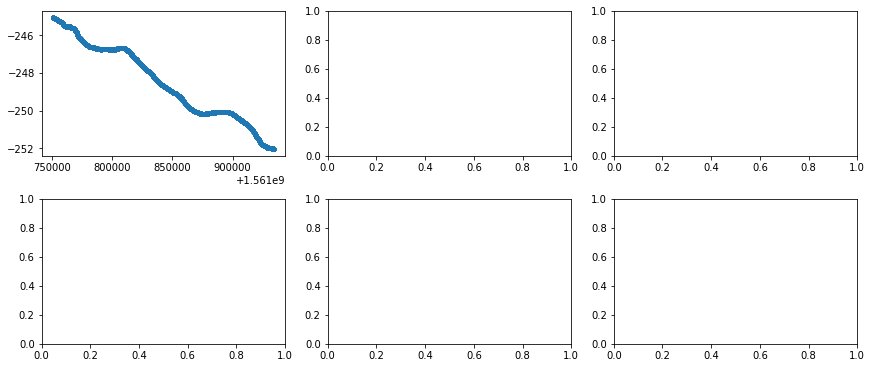

In [23]:
l1 = D1.min()            #Trolley vs st 22
h1 = D1.max()
l2 = D2.min()
h2 = D2.max()
l3 = D3.min()
h3 = D3.max()
l4 = D4.min()
h4 = D4.max()
l5 = D5.min()
h5 = D5.max()
l6 = D6.min()
h6 = D6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

#axs[0,0].plot(T1 , D1)
axs[0,0].plot(T1 , D1, '.')
#axs[0,0].plot(day-6400-time_deleted + run_start, [l1,h1], 'r', 2*day-6400-time_deleted + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].plot(T1, line(T1, np.average(slopes1), np.average(intercepts1)), 'k', label = "Two-point method")
axs[0,0].plot(T1, line(T1, z1[0], z1[1]), "c", label = "line of best fit")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

#axs[0,1].plot(T2 , D2)
axs[0,1].plot(T2 , D2, '.')
#axs[0,1].plot(day-6400-time_deleted + run_start, [l2,h2], 'r', 2*day-6400-time_deleted + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].plot(T2, line(T2, np.average(slopes2), np.average(intercepts2)), 'k', label = "Two-point method")
axs[0,1].plot(T2, line(T2, z2[0], z2[1]), "c", label = "line of best fit")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

#axs[0,2].plot(T3 , D3)
axs[0,2].plot(T3 , D3, '.')
#axs[0,2].plot(day-6400-time_deleted + run_start, [l3,h3], 'r', 2*day-6400-time_deleted + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].plot(T3, line(T3, np.average(slopes3), np.average(intercepts3)), 'k', label = "Two-point method")
axs[0,2].plot(T3, line(T3, z3[0], z3[1]), "c", label = "line of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(T4 , D4, '.')
#axs[1,0].plot(day-6400-time_deleted + run_start, [l4,h4], 'r', 2*day-6400-time_deleted + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].plot(T4, line(T4, np.average(slopes4), np.average(intercepts4)), 'k', label = "Two-point method")
axs[1,0].plot(T4, line(T4, z4[0], z4[1]), "c", label = "line of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(T5 , D5, '.')
#axs[1,1].plot(day-6400-time_deleted + run_start, [l5,h5], 'r', 2*day-6400-time_deleted + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].plot(T5, line(T5, np.average(slopes5), np.average(intercepts5)), 'k', label = "Two-point method")
axs[1,1].plot(T5, line(T5, z5[0], z5[1]), "c", label = "line of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(T6 , D6, '.')
#axs[1,2].plot(day-6400-time_deleted + run_start, [l6,h6], 'r', 2*day-6400-time_deleted + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].plot(T6, line(T6, np.average(slopes6), np.average(intercepts6)), 'k', label = "Two-point method")
axs[1,2].plot(T6, line(T6, z6[0], z6[1]), "c", label = "line of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Trolley")
plt.show()

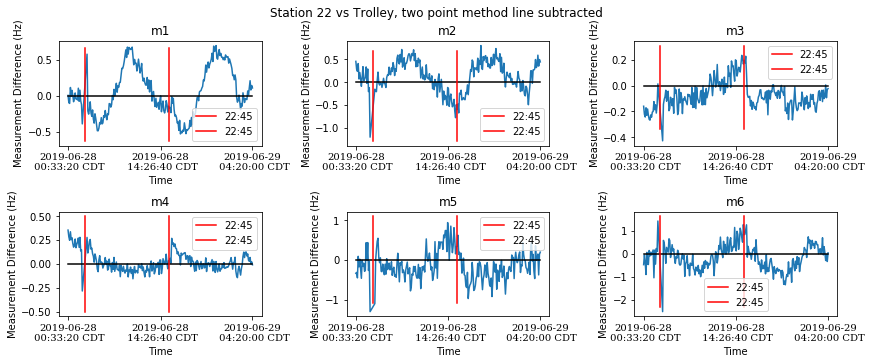

In [20]:
l1 = np.min(D1 - line(T1, z1[0], z1[1]))            #Trolley vs st 22 two point method subtracted.
h1 = np.max(D1 - line(T1, z1[0], z1[1]))
l2 = np.min(D2 - line(T2, z2[0], z2[1]))
h2 = np.max(D2 - line(T2, z2[0], z2[1]))
l3 = np.min(D3 - line(T3, z3[0], z3[1]))
h3 = np.max(D3 - line(T3, z3[0], z3[1]))
l4 = -.5 #np.min(D4 - line(T4, z4[0], z4[1]))
h4 =  .5#np.max(D4 - line(T4, z4[0], z4[1]))
l5 = np.min(D5 - line(T5, z5[0], z5[1]))
h5 = np.max(D5 - line(T5, z5[0], z5[1]))
l6 = np.min(D6 - line(T6, z6[0], z6[1]))
h6 = np.max(D6 - line(T6, z6[0], z6[1]))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(T1, D1 - line(T1, slope_avg1, intercept_avg1))
axs[0,0].plot([T1.min(), T1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(T2, D2 - line(T2, slope_avg2, intercept_avg2))
axs[0,1].plot([T2.min(), T2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(T3, D3 - line(T3, slope_avg3, intercept_avg3))
axs[0,2].plot([T3.min(), T3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(T4, D4 - line(T4, slope_avg4, intercept_avg4))
axs[1,0].plot([T4.min(), T4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(T5, D5 - line(T5, slope_avg5, intercept_avg5))
axs[1,1].plot([T5.min(), T5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(T6, D6 - line(T6, slope_avg6, intercept_avg6))
axs[1,2].plot([T6.min(), T6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Trolley, two point method line subtracted")
plt.show()

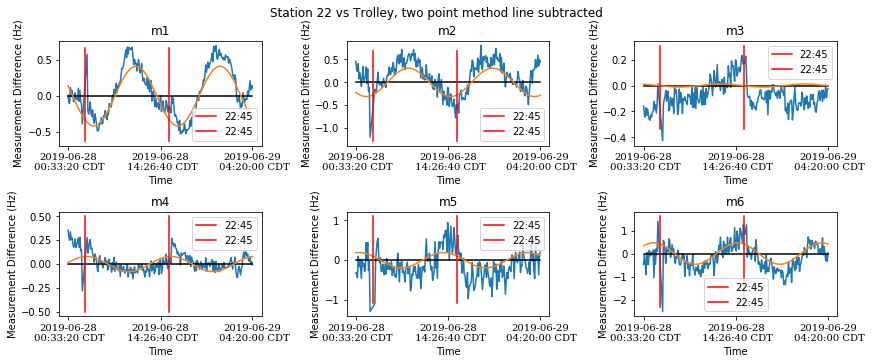

In [26]:
l1 = np.min(D1 - line(T1, z1[0], z1[1]))            #Trolley vs st 22 two point method subtracted, cos fit
h1 = np.max(D1 - line(T1, z1[0], z1[1]))
l2 = np.min(D2 - line(T2, z2[0], z2[1]))
h2 = np.max(D2 - line(T2, z2[0], z2[1]))
l3 = np.min(D3 - line(T3, z3[0], z3[1]))
h3 = np.max(D3 - line(T3, z3[0], z3[1]))
l4 = -.5 #np.min(D4 - line(T4, z4[0], z4[1]))
h4 =  .5#np.max(D4 - line(T4, z4[0], z4[1]))
l5 = np.min(D5 - line(T5, z5[0], z5[1]))
h5 = np.max(D5 - line(T5, z5[0], z5[1]))
l6 = np.min(D6 - line(T6, z6[0], z6[1]))
h6 = np.max(D6 - line(T6, z6[0], z6[1]))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(T1, D1 - line(T1, slope_avg1, intercept_avg1))
axs[0,0].plot([T1.min(), T1.max()], [0,0], 'k')
axs[0,0].plot(T1, cos(T1, A1, phi1))
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_xticks([T1[0], T1[len(T1)/2], T1[-1]])
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(T2, D2 - line(T2, slope_avg2, intercept_avg2))
axs[0,1].plot([T2.min(), T2.max()], [0,0], 'k')
axs[0,1].plot(T2, cos(T2, A2, phi2))
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_xticks([T2[0], T2[len(T2)/2], T2[-1]])
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(T3, D3 - line(T3, slope_avg3, intercept_avg3))
axs[0,2].plot([T3.min(), T3.max()], [0,0], 'k')
axs[0,2].plot(T3, cos(T3, A3, phi3))
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_xticks([T3[0], T3[len(T3)/2], T3[-1]])
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(T4, D4 - line(T4, slope_avg4, intercept_avg4))
axs[1,0].plot([T4.min(), T4.max()], [0,0], 'k')
axs[1,0].plot(T4, cos(T4, A4, phi4))
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_xticks([T4[0], T4[len(T4)/2], T4[-1]])
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(T5, D5 - line(T5, slope_avg5, intercept_avg5))
axs[1,1].plot([T5.min(), T5.max()], [0,0], 'k')
axs[1,1].plot(T5, cos(T5, A5, phi5))
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_xticks([T5[0], T5[len(T5)/2], T5[-1]])
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(T6, D6 - line(T6, slope_avg6, intercept_avg6))
axs[1,2].plot([T6.min(), T6.max()], [0,0], 'k')
axs[1,2].plot(T6, cos(T6, A6, phi6))
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_xticks([T6[0], T6[len(T6)/2], T6[-1]])
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Trolley, two point method line subtracted")
plt.show()

In [21]:
corr_diff1 = y1 - np.polyval([slope_avg1, intercept_avg1], T)
vars1, cov1 = curve_fit(cos, T, corr_diff1)
print(vars1)

corr_diff2 = y2 - np.polyval([slope_avg2, intercept_avg2], T)
vars2, cov2 = curve_fit(cos, T, corr_diff2, [.4, 43200])
print(vars2)

corr_diff3 = y3 - np.polyval([slope_avg3, intercept_avg3], T)
vars3, cov3 = curve_fit(cos, T, corr_diff3)
print(vars3)

corr_diff4 = y4 - np.polyval([slope_avg4, intercept_avg4], T)
vars4, cov4 = curve_fit(cos, T, corr_diff4)
print(vars4)

corr_diff5 = y5 - np.polyval([slope_avg5, intercept_avg5], T)
vars5, cov5 = curve_fit(cos, T, corr_diff5)
print(vars5)

corr_diff6 = y6 - np.polyval([slope_avg6, intercept_avg6], T)
vars6, cov6 = curve_fit(cos, T, corr_diff6)
print(vars6)

A1 = vars1[0]
phi1 = vars1[1]

A2 = vars2[0]
phi2 = vars2[1]

A3 = vars3[0]
phi3 = vars3[1]

A4 = vars4[0]
phi4 = vars4[1]

A5 = vars5[0]
phi5 = vars5[1]

A6 = vars6[0]
phi6 = vars6[1]

[0.41592538 2.51390463]
[3.10264230e-01 4.32005499e+04]
[0.01167309 1.81065067]
[ 0.07909926 -0.09561659]
[0.19225407 1.03603136]
[0.46419396 0.55288318]


In [22]:
yy1 = D1 - line(T1, slope_avg1, intercept_avg1)
yy2 = D2 - line(T2, slope_avg2, intercept_avg2)

In [23]:
#estimating the variance by taking a chunk of data and making red. chi2 = 1
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff1[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance1 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance1)
print(np.sqrt(variance1))

##Now m2
sample_vals = np.array([])
sample_t = np.array([])
for i in range(15000):
    sample_vals = np.append(sample_vals, corr_diff2[i])
    sample_t    = np.append(sample_t , i)
    
fit = np.polyfit(sample_t, sample_vals, 2)
dof = len(sample_vals) - 3
variance2 = Variance(sample_vals, np.polyval(fit, sample_t), dof)
print(variance2)
print(np.sqrt(variance2))


0.7127087190765978
0.844220776264478
3.1748619220523193
1.781814222092842


In [24]:
print(phi1-phi2)

-43198.036042974694


In [25]:
m1 = MovingAvg(corr_diff1, 7200)
print("m1 done")
m2 = MovingAvg(corr_diff2, 7200)
print("m2 done")
m3 = MovingAvg(corr_diff3, 7200)
print("m3 done")
m4 = MovingAvg(corr_diff4, 7200)
print("m4 done")
m5 = MovingAvg(corr_diff5, 7200)
print("m5 done")
m6 = MovingAvg(corr_diff6, 7200)
print("m6 done")



0iterations done
86400iterations done
172800iterations done
m1 done
0iterations done
86400iterations done
172800iterations done
m2 done
0iterations done
86400iterations done
172800iterations done
m3 done
0iterations done
86400iterations done
172800iterations done
m4 done
0iterations done
86400iterations done
172800iterations done
m5 done
0iterations done
86400iterations done
172800iterations done
m6 done


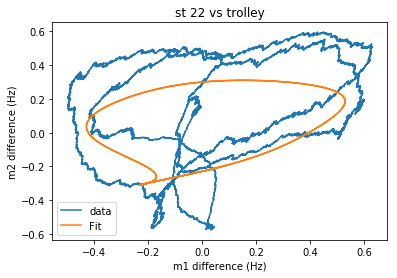

In [31]:
plt.plot(m1, m2, label = "data")
plt.plot(harm1, harm2, label = "Fit")
plt.xlabel("m1 difference (Hz)")
plt.ylabel("m2 difference (Hz)")
plt.title("st 22 vs trolley")
plt.legend()

In [ ]:
x = np.arange(0, 4 * np.pi, 0.01)
f = np.sin(x)
g = np.sin(x + np.pi/6)

fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(5)
axs.plot(Comp1, Comp2, '.')
axs.set_aspect('equal')

In [22]:
#ax^2 + bx + c

a1, b1, c1 = DayParFit(T1, D1, start1)
#print("a1 = " + str(a1))
#print("b1 = " + str(b1))
#print("c1 = " + str(c1))
print(len(c1))
a1 = np.average(a1)
b1 = np.average(b1)
c1 = np.average(c1)

a2, b2, c2 = DayParFit(T2, D2, start2)
#print("a2 = " + str(a2))
#print("b2 = " + str(b2))
#print("c2 = " + str(c2))
print(len(c2))
a2 = np.average(a2)
b2 = np.average(b2)
c2 = np.average(c2)

a3, b3, c3 = DayParFit(T3, D3, start3)
#print("a3 = " + str(a3))
#print("b3 = " + str(b3))
#print("c3 = " + str(c3))
print(len(c3))
a3 = np.average(a3)
b3 = np.average(b3)
c3 = np.average(c3)

a4, b4, c4 = DayParFit(T4, D4, start4)
#print("a4 = " + str(a4))
#print("b4 = " + str(b4))
#print("c4 = " + str(c4))
print(len(c4))
a4 = np.average(a4)
b4 = np.average(b4)
c4 = np.average(c4)

a5, b5, c5 = DayParFit(T5, D5, start5)
#print("a5 = " + str(a5))
#print("b5 = " + str(b5))
#print("c5 = " + str(c5))
print(len(c5))
a5 = np.average(a5)
b5 = np.average(b5)
c5 = np.average(c5)

a6, b6, c6 = DayParFit(T6, D6, start6)
#print("a6 = " + str(a6))
#print("b6 = " + str(b6))
#print("c6 = " + str(c6))
print(len(c6))
a6 = np.average(a6)
b6 = np.average(b6)
c6 = np.average(c6)


#Ax^2 + Bx + C
A1, B1, C1 = np.polyfit(T1, D1, 2)
A2, B2, C2 = np.polyfit(T2, D2, 2)
A3, B3, C3 = np.polyfit(T3, D3, 2)
A4, B4, C4 = np.polyfit(T4, D4, 2)
A5, B5, C5 = np.polyfit(T5, D5, 2)
A6, B6, C6 = np.polyfit(T6, D6, 2)

print("A1 = " + str(A1))
print("B1 = " + str(B1))
print("C1 = " + str(C1))

print("A2 = " + str(A2))
print("B2 = " + str(B2))
print("C2 = " + str(C2))

print("A3 = " + str(A3))
print("B3 = " + str(B3))
print("C3 = " + str(C3))

print("A4 = " + str(A4))
print("B4 = " + str(B4))
print("C4 = " + str(C4))

print("A5 = " + str(A5))
print("B5 = " + str(B5))
print("C5 = " + str(C5))

print("A6 = " + str(A6))
print("B6 = " + str(B6))
print("C6 = " + str(C6))

21
7
4
9
9
1
A1 = -3.828497889754393e-12
B1 = 0.011996203090945082
C1 = -9396877.362951797
A2 = 1.3315646612780463e-12
B2 = -0.004158794538646888
C2 = 3248392.4290109454
A3 = -2.3413322096551786e-11
B3 = 0.07313853836473574
C3 = -57117258.94532558
A4 = 1.360098687715965e-11
B4 = -0.04248136506455951
C4 = 33173072.045052473
A5 = -1.5289341571394373e-11
B5 = 0.04775408267890735
C5 = -37284933.591291346
A6 = 1.1687158084746867e-11
B6 = -0.036501413436456034
C6 = 28500923.890008654


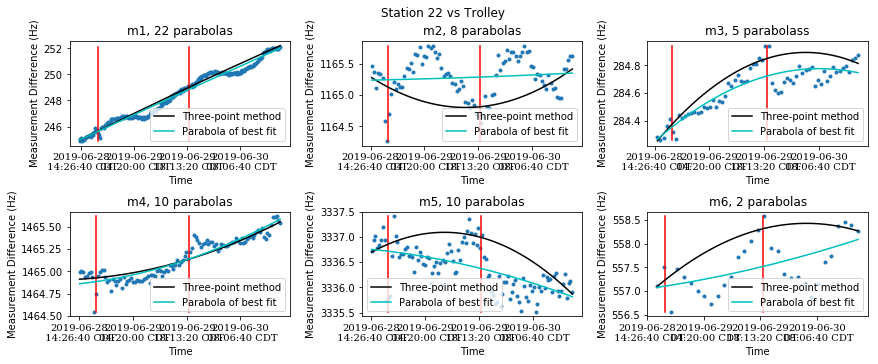

In [23]:
l1 = D1.min()
h1 = D1.max()
l2 = D2.min()
h2 = D2.max()
l3 = D3.min()
h3 = D3.max()
l4 = D4.min()
h4 = D4.max()
l5 = D5.min()
h5 = D5.max()
l6 = D6.min()
h6 = D6.max()

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

#axs[0,0].plot(T1 , D1)
axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400 + run_start, [l1,h1], 'r', 2*day-6400 + run_start, [l1,h1], 'r')#, label = "22:45")
axs[0,0].plot(T1, np.polyval(np.array([a1, b1, c1]), T1), 'k', label = "Three-point method")
axs[0,0].plot(T1, np.polyval(np.array([A1, B1, C1]), T1), "c", label = "Parabola of best fit")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1, 22 parabolas')#

#axs[0,1].plot(T2 , D2)
axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400 + run_start, [l2,h2], 'r', 2*day-6400 + run_start, [l2,h2], 'r')#, label = "22:45")
axs[0,1].plot(T2, np.polyval(np.array([a2, b2, c2]), T2), 'k', label = "Three-point method")
axs[0,1].plot(T2, np.polyval(np.array([A2, B2, C2]), T2), "c", label = "Parabola of best fit")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2, 8 parabolas')

#axs[0,2].plot(T3 , D3)
axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400 + run_start, [l3,h3], 'r', 2*day-6400 + run_start, [l3,h3], 'r')#, label = "22:45")
axs[0,2].plot(T3, np.polyval(np.array([a3, b3, c3]), T3), 'k', label = "Three-point method")
axs[0,2].plot(T3, np.polyval(np.array([A3, B3, C3]), T3), "c", label = "Parabola of best fit")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3, 5 parabolass')

#axs[1,0].plot(T4 , D4)
axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400 + run_start, [l4,h4], 'r', 2*day-6400 + run_start, [l4,h4], 'r')#, label = "22:45")
axs[1,0].plot(T4, np.polyval(np.array([a4, b4, c4]), T4), 'k', label = "Three-point method")
axs[1,0].plot(T4, np.polyval(np.array([A4, B4, C4]), T4), "c", label = "Parabola of best fit")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4, 10 parabolas')

#axs[1,1].plot(T5 , D5)
axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400 + run_start, [l5,h5], 'r', 2*day-6400 + run_start, [l5,h5], 'r')#, label = "22:45")
axs[1,1].plot(T5, np.polyval(np.array([a5, b5, c5]), T5), 'k', label = "Three-point method")
axs[1,1].plot(T5, np.polyval(np.array([A5, B5, C5]), T5), "c", label = "Parabola of best fit")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5, 10 parabolas')

#axs[1,2].plot(T6 , D6)
axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400 + run_start, [l6,h6], 'r', 2*day-6400 + run_start, [l6,h6], 'r')#, label = "22:45")
axs[1,2].plot(T6, np.polyval(np.array([a6, b6, c6]), T6), 'k', label = "Three-point method")
axs[1,2].plot(T6, np.polyval(np.array([A6, B6, C6]), T6), "c", label = "Parabola of best fit")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6, 2 parabolas')
fig.suptitle("Station 22 vs Trolley")
plt.show()

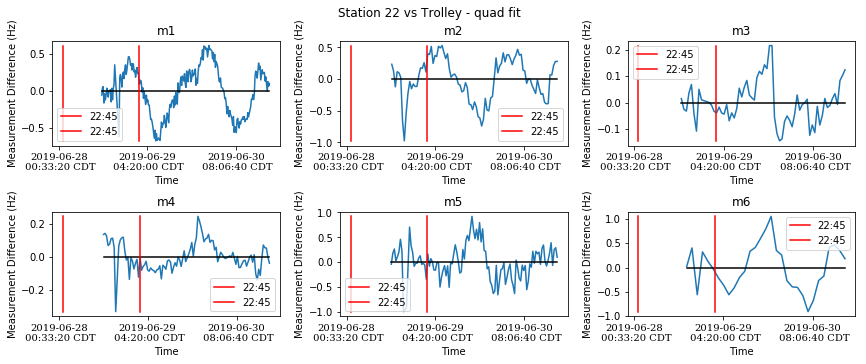

In [24]:
l1 = np.min(D1 - np.polyval([A1, B1, C1], T1))            #Trolley vs st 22 parabola of best fit subtracted.
h1 = np.max(D1 - np.polyval([A1, B1, C1], T1))
l2 = np.min(D2 - np.polyval([A2, B2, C2], T2))
h2 = np.max(D2 - np.polyval([A2, B2, C2], T2))
l3 = np.min(D3 - np.polyval([A3, B3, C3], T3))
h3 = np.max(D3 - np.polyval([A3, B3, C3], T3))
l4 = np.min(D4 - np.polyval([A4, B4, C4], T4))
h4 = np.max(D4 - np.polyval([A4, B4, C4], T4))
l5 = np.min(D5 - np.polyval([A5, B5, C5], T5))
h5 = np.max(D5 - np.polyval([A5, B5, C5], T5))
l6 = np.min(D6 - np.polyval([A6, B6, C6], T6))
h6 = np.max(D6 - np.polyval([A6, B6, C6], T6))

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(12)

axs[0,0].plot(T1, D1 - np.polyval([A1, B1, C1], T1))
axs[0,0].plot([T1.min(), T1.max()], [0,0], 'k')
#axs[0,0].plot(T1 , D1, '.')
axs[0,0].plot(day-6400-time_deleted + run_start, [l1,h1], 'r', 2*day-6400-time_deleted + run_start, [l1,h1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(T2, D2 - np.polyval([A2, B2, C2], T2))
axs[0,1].plot([T2.min(), T2.max()], [0,0], 'k')
#axs[0,1].plot(T2 , D2, '.')
axs[0,1].plot(day-6400-time_deleted + run_start, [l2,h2], 'r', 2*day-6400-time_deleted + run_start, [l2,h2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Difference (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(T3, D3 - np.polyval([A3, B3, C3], T3))
axs[0,2].plot([T3.min(), T3.max()], [0,0], 'k')
#axs[0,2].plot(T3 , D3, '.')
axs[0,2].plot(day-6400-time_deleted + run_start, [l3,h3], 'r', 2*day-6400-time_deleted + run_start, [l3,h3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Difference (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(T4, D4 - np.polyval([A4, B4, C4], T4))
axs[1,0].plot([T4.min(), T4.max()], [0,0], 'k')
#axs[1,0].plot(T4 , D4, '.')
axs[1,0].plot(day-6400-time_deleted + run_start, [l4,h4], 'r', 2*day-6400-time_deleted + run_start, [l4,h4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Difference (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(T5, D5 - np.polyval([A5, B5, C5], T5))
axs[1,1].plot([T5.min(), T5.max()], [0,0], 'k')
#axs[1,1].plot(T5 , D5, '.')
axs[1,1].plot(day-6400-time_deleted + run_start, [l5,h5], 'r', 2*day-6400-time_deleted + run_start, [l5,h5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Difference (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(T6, D6 - np.polyval([A6, B6, C6], T6))
axs[1,2].plot([T6.min(), T6.max()], [0,0], 'k')
#axs[1,2].plot(T6 , D6, '.')
axs[1,2].plot(day-6400-time_deleted + run_start, [l6,h6], 'r', 2*day-6400-time_deleted + run_start, [l6,h6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Difference (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Station 22 vs Trolley - quad fit")
plt.show()

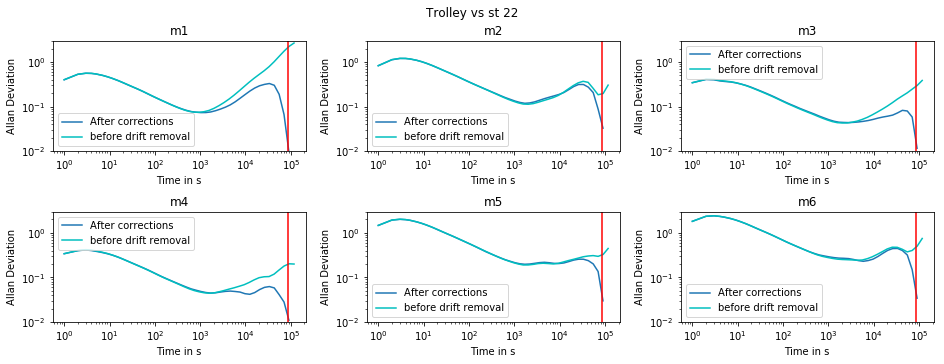

In [25]:
T = sl_moment_df.index.to_numpy() - (run_start + 61200)
t = np.logspace(0, math.log(len(st22m1_list),10), num = 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data
#Computing Allan Deviations of the differences:
(t1, ad1, ade, adn) = allantools.oadev(y1 - np.polyval([slope_avg1, intercept_avg1], T), rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(t2, ad2, ade, adn) = allantools.oadev(y2 - np.polyval([slope_avg2, intercept_avg2], T), rate=r, data_type="freq", taus = t)
(t3, ad3, ade, adn) = allantools.oadev(y3 - np.polyval([slope_avg3, intercept_avg3], T), rate=r, data_type="freq", taus = t)  
(t4, ad4, ade, adn) = allantools.oadev(y4 - np.polyval([slope_avg4, intercept_avg4], T), rate=r, data_type="freq", taus = t)
(t5, ad5, ade, adn) = allantools.oadev(y5 - np.polyval([slope_avg5, intercept_avg5], T), rate=r, data_type="freq", taus = t) 
(t6, ad6, ade, adn) = allantools.oadev(y6 - np.polyval([slope_avg6, intercept_avg6], T), rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgt1 = t1[np.where(ad1==ad1.min())][0]
avgt2 = t2[np.where(ad2==ad2.min())][0]
avgt3 = t3[np.where(ad3==ad3.min())][0]
avgt4 = t4[np.where(ad4==ad4.min())][0]
avgt5 = t5[np.where(ad5==ad5.min())][0]
avgt6 = t6[np.where(ad6==ad6.min())][0]

#Plots Allan Deviation
day  = np.array([86400, 86400])
ad1m = np.array([min(ad1), max(ad1)])
ad2m = np.array([min(ad2), max(ad2)])
ad3m = np.array([min(ad3), max(ad3)])
ad4m = np.array([min(ad4), max(ad4)])
ad5m = np.array([min(ad5), max(ad5)])
ad6m = np.array([min(ad6), max(ad6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True) #This is St22 vs Trolley
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(t1, ad1, label = "After corrections")
axs[0,0].plot(tb1, adb1, 'c', label = "before drift removal")
axs[0,0].plot([86400,86400],[.01,3], 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_ylim(.01,3)                                                                          
axs[0,0].set_yscale('log')
axs[0,0].legend()
axs[0,0].set_xlabel("Time in s")
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(t2,ad2, label = "After corrections")
axs[0,1].plot(tb2,adb2, 'c', label = "before drift removal")
axs[0,1].plot([86400,86400],[.01,3], 'r')
axs[0,1].set_ylim(.01,3)                                                                          
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].set_xlabel("Time in s")
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(t3,ad3, label = "After corrections")
axs[0,2].plot(tb3,adb3, 'c', label = "before drift removal")
axs[0,2].plot([86400,86400],[.01,3], 'r')
axs[0,2].set_ylim(.01,3)                                                                          
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].legend()
axs[0,2].set_xlabel("Time in s")
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(t4,ad4, label = "After corrections")
axs[1,0].plot(tb4,adb4, 'c', label = "before drift removal")
axs[1,0].plot([86400,86400],[.01,3], 'r')
axs[1,0].set_ylim(.01,3)                                                                          
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].legend()
axs[1,0].set_xlabel("Time in s")
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(t5,ad5, label = "After corrections")
axs[1,1].plot(tb5,adb5, 'c', label = "before drift removal")
axs[1,1].plot([86400,86400],[.01,3], 'r')
axs[1,1].set_ylim(.01,3)                                                                          
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].legend()
axs[1,1].set_xlabel("Time in s")
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(t6,ad6, label = "After corrections")
axs[1,2].plot(tb6,adb6, 'c', label = "before drift removal")
axs[1,2].plot([86400,86400],[.01,3], 'r')
axs[1,2].set_ylim(.01,3)                                                                          
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].legend()
axs[1,2].set_xlabel("Time in s")
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs st 22")

plt.show()

In [43]:
Y1 = y1 - np.polyval([slope_avg1, intercept_avg1],T)
Y2 = y2 - np.polyval([slope_avg2, intercept_avg2],T)
Y3 = y3 - np.polyval([slope_avg3, intercept_avg3],T)
Y4 = y4 - np.polyval([slope_avg4, intercept_avg4],T)
Y5 = y5 - np.polyval([slope_avg5, intercept_avg5],T)
Y6 = y6 - np.polyval([slope_avg6, intercept_avg6],T)

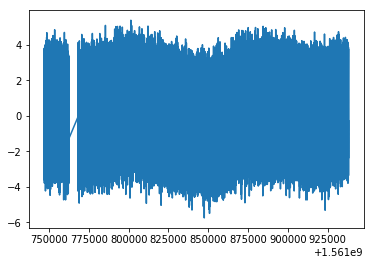

In [44]:
plt.plot(T, Y2)

In [37]:
yy1 = MovingAvg(Y1, avgt1)
print("ys done")

0iterations done
86400iterations done
172800iterations done
ys done


In [45]:
yy1 = MovingAvg(yy1, 1000)

0iterations done
86400iterations done
172800iterations done


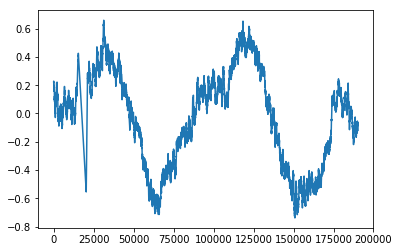

In [46]:
plt.plot(yy1)

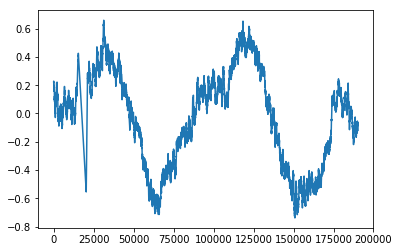

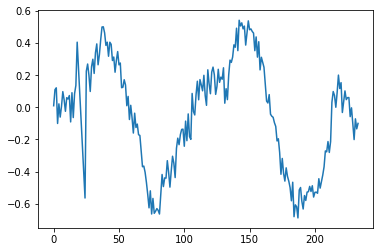

In [56]:
plt.plot(yy1)
plt.show()

plt.plot(D1 - line(T1, slope_avg1, intercept_avg1))

0iterations done


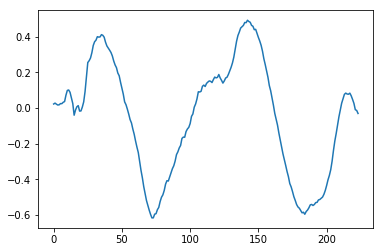

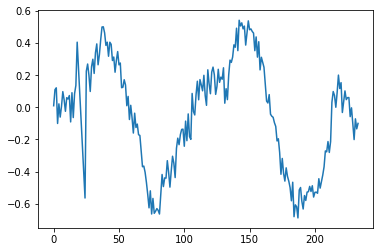

In [59]:
dd1 = MovingAvg(D1 - line(T1, slope_avg1, intercept_avg1), 10)
plt.plot(dd1)
plt.show()
plt.plot(D1 - line(T1, slope_avg1, intercept_avg1))